<a href="https://colab.research.google.com/github/pratyushghosh/CS4243_Mini_Project/blob/main/Combined_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!nvidia-smi

Fri Nov 11 10:48:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |    480MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download Required Items

## Download Dataset


In [1]:
!gdown https://drive.google.com/uc?id=1QI6qIIV0ZMy6ytAlHYTMOKQBvEuZLtJM

Downloading...
From: https://drive.google.com/uc?id=1QI6qIIV0ZMy6ytAlHYTMOKQBvEuZLtJM
To: /content/Combined_Frames.zip
100% 419M/419M [00:04<00:00, 86.5MB/s]


In [2]:
!unzip -q /content/Combined_Frames.zip

## Download Saved Models

In [3]:
!gdown https://drive.google.com/uc?id=11Qwa_MFNyBFEogV8dEusk_CuaVnlXm-v

Downloading...
From: https://drive.google.com/uc?id=11Qwa_MFNyBFEogV8dEusk_CuaVnlXm-v
To: /content/pose_estimator.h5
100% 353k/353k [00:00<00:00, 138MB/s]


## Download and install OpenPose

In [4]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]

if not exists(project_name):
  !rm -rf openpose
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  print("install new CMake because of CUDA10")
  cmake_version = 'cmake-3.20.2-linux-x86_64.tar.gz'
  if not exists(cmake_version):
    !wget -q 'https://cmake.org/files/v3.20/{cmake_version}'
  !tar xfz {cmake_version} --strip-components=1 -C /usr/local

  print("clone openpose")
  !git clone -q --depth 1 $git_repo_url
  print("install system dependencies")
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  print("build openpose")
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

install new CMake because of CUDA10
clone openpose
install system dependencies
Selecting previously unselected package libgflags2.2.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selec

# Initialisation

In [61]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [62]:
# PLEASE PLACE IMAGE IN THE BELOW FOLDER
!mkdir input_image_storage

mkdir: cannot create directory ‘input_image_storage’: File exists


In [72]:
filename = "carrying2(LIAO TIANCHANG).mp4_frame3.jpg"
IMAGE_PATH = f"/content/input_image_storage/{filename}"

In [73]:
RESULT = -1

# Detect Weapons

In [74]:
# add model here

In [75]:
hasWeapons = True

# Detect Poses

In [76]:
import json
def extractKeyPoints(folder):

  mainList = []
  for root, dirs, files in os.walk(folder):
    for name in files:
      if name.endswith('.json'):
        with open(os.path.join(root, name), 'r') as f:
          data = json.load(f)

        # as defined by project scope, there is only 1 person in an image
        for person in data['people']:
          return person['pose_keypoints_2d']

In [77]:
pose_estimator = tf.keras.models.load_model("/content/pose_estimator.h5")
pose_estimator.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 75)]              0         
                                                                 
 dense_102 (Dense)           (None, 128)               9728      
                                                                 
 dense_103 (Dense)           (None, 64)                8256      
                                                                 
 dense_104 (Dense)           (None, 32)                2080      
                                                                 
 dense_105 (Dense)           (None, 64)                2112      
                                                                 
 dense_106 (Dense)           (None, 32)                2080      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0  

In [78]:
def notNormal():
  !cd openpose && ./build/examples/openpose/openpose.bin --hand --image_dir /content/input_image_storage --write_json /content/output_jsons/ --display 0 --render_pose 0
  body_keypoints = np.array(extractKeyPoints("/content/output_jsons")).reshape(1,-1)

  test = tf.data.Dataset.from_tensor_slices(body_keypoints).batch(32).prefetch(tf.data.AUTOTUNE)
  preds = pose_estimator.predict(test)[0]
  isThreat = 2 if tf.argmax(preds) == 1 else 1
  return isThreat

# Show results

In [79]:
if hasWeapons:
  RESULT = notNormal()
else:
  RESULT = 0

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 5.432958 seconds.
1/1 [==============================] - 0s 55ms/step


The image below is of the Carrying class.


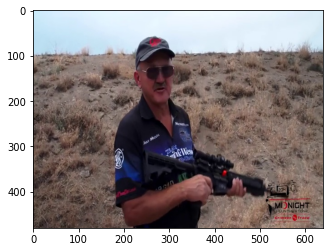

In [71]:
classes = {
    -1: "Unknown",
    0: "Normal",
    1: "Carrying",
    2: "Threat"
}

print(f"The image below is of the {classes[RESULT]} class.")
img = cv2.imread(IMAGE_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()